# Credit Card Fraud Detection

Let's try and detect credit card frauds!

<img src="fig/credit_card_fraud.jpg">

This example uses a dataset from the kaggle platform, you can find it [here](https://www.kaggle.com/mlg-ulb/creditcardfraud).

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in **two days**.

We have downloaded the csv file for you, let's take a look!

In [1]:
source('src/lib.R')

In [2]:
# import the data
creditcard = read_csv('data/creditcard.csv', col_types = cols())

## Let's have a look at the data

The data is composed of only numerical input variables (V1, V2, ... V28 are the result of a PCA transformation). Unfortunately, due to confidentiality issues, we do not have the original features and more background information about the data. The only original features are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount.

In [3]:
creditcard %>% head()

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,...,-0.018306778,0.277837576,-0.11047391,0.06692808,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,...,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,...,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,...,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
2,-1.1582331,0.87773676,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,...,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,...,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


Feature 'Class' is our label, it equals 1 in case of fraud and 0 otherwise:

In [4]:
creditcard %>% group_by(Class) %>%
  summarise(Transactions = n(), Average_Amount = mean(Amount))

Class,Transactions,Average_Amount
0,284315,88.29102
1,492,122.21132


We can take a look at the amounts:

Transactions,Average_Amount,Minimum_Amount,Maximum_Amount
284807,88.34962,0,25691.16


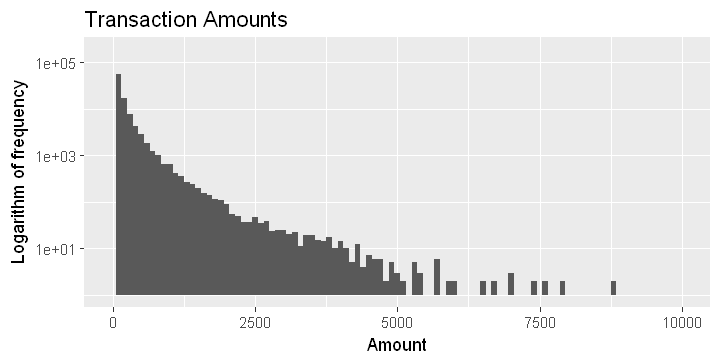

In [5]:
creditcard %>%
  summarise(Transactions = n(),
            Average_Amount = mean(Amount),
            Minimum_Amount = min(Amount),
            Maximum_Amount = max(Amount))

options(repr.plot.width=6, repr.plot.height=3)
creditcard %>%
  ggplot(aes(x = Amount)) + geom_histogram(binwidth = 100) + 
  labs(title='Transaction Amounts', y='Logarithm of frequency') +
  scale_y_log10() + xlim(c(0,10000)) #+ theme(legend.position = "none")

## Correlations

Let's calculate the Pearson correlation for the data.

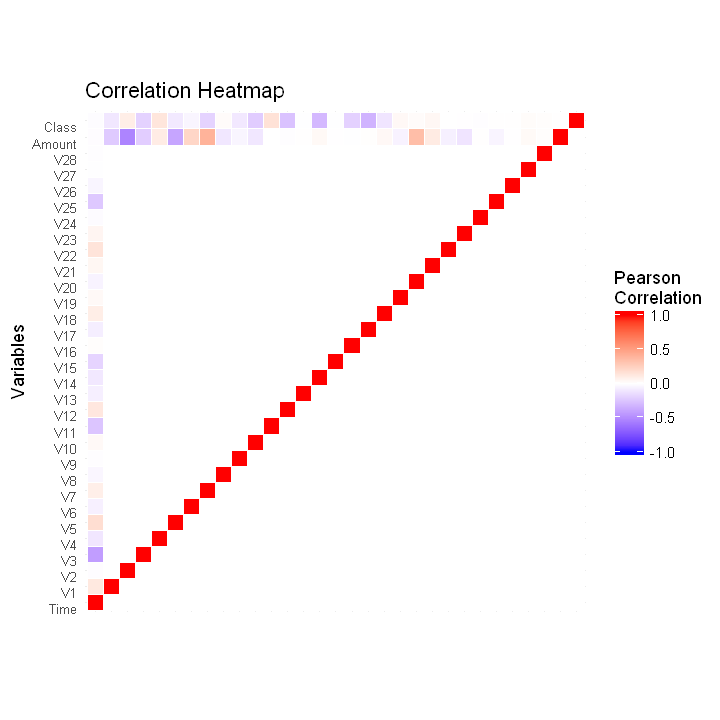

In [6]:
correlations = creditcard  %>% cor(use = "complete.obs", method = "pearson")

correlations[upper.tri(correlations)] = 0

correlations_gathered = as.data.frame(correlations) %>% 
  mutate(Var1 = factor(row.names(.), levels=row.names(.))) %>% 
  gather(key = Var2, value = value, -Var1, na.rm = TRUE, factor_key = TRUE) 

options(repr.plot.width=6, repr.plot.height=6)
ggplot(data = correlations_gathered, aes(Var2, Var1, fill = value)) + 
  geom_tile(color = "white")+
  scale_fill_gradient2(low = "blue", high = "red", mid = "white",
                       midpoint = 0, limit = c(-1,1), space = "Lab",
                       name="Pearson\nCorrelation") +
  theme_minimal() +
  theme(axis.text.y = element_text(angle = 0, vjust = 1,
                                   size = 8, hjust = 1),
        axis.text.x = element_blank()) + xlab("") + ylab('Variables') +
 ggtitle('Correlation Heatmap') +
 coord_fixed()

## Let's take a subsample

Since the original dataset is huge, let's try taking a subsample, **just for the sake of using less time and resources for this example**

In [7]:
set.seed(123)

subsample = creditcard %>% nrow %>% seq_len %>% createDataPartition(times = 1, p = 0.1, list = F)
data_raw = creditcard %>% slice(subsample)

data_raw %>% head

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
2,-1.1582331,0.8777368,1.5487178,0.4030339,-0.40719338,0.09592146,0.5929407,-0.27053268,0.8177393,...,-0.009430697,0.7982785,-0.137458080,0.141266984,-0.2060096,0.50229222,0.21942223,0.21515315,69.99,0
26,-0.5299123,0.8738916,1.3472473,0.1454567,0.41420886,0.10022309,0.7112061,0.17606596,-0.2867169,...,0.046949067,0.2081049,-0.185548347,0.001030660,0.0988157,-0.55290360,-0.07328808,0.02330704,6.14,0
34,-0.7622557,0.1277678,2.6500564,-1.8756628,-0.89335640,-0.26871489,-0.4198636,0.14623341,-0.8696353,...,0.433349642,1.2604027,-0.404700036,0.094945523,0.4809760,-0.09068468,0.31922297,0.13559993,15.99,0
38,0.1583318,0.8726874,0.9655246,1.8021272,0.13902198,0.11086310,0.5590792,-0.02907093,-0.3949123,...,0.116269966,0.6916850,0.121112830,0.116142168,-1.1127250,-0.30336915,0.32753280,0.25562138,21.76,0
39,-0.5540646,0.2157283,0.8442646,-0.7530673,0.03484847,-0.55859725,1.0904010,-0.20387323,0.2623936,...,0.212133973,0.7023376,-0.005700602,0.147346442,0.2456520,-0.44045621,0.14713042,0.13946773,120.96,0
50,-0.5715208,1.0716004,1.2801102,0.5427800,0.57443899,-0.25935927,1.0611484,-0.41097197,-0.1791302,...,0.003558520,0.5612405,-0.199286720,0.001387389,-0.1795300,-0.37411573,0.07164145,-0.17551047,9.79,0


Let's see what's left:

In [8]:
data_raw %>% group_by(Class) %>%
  summarise(Transactions = n())

Class,Transactions
0,28442
1,42


## Pre-processing the data

In [9]:
## let's set up the features...
features =
    data_raw %>%
    select(Time, # select features
           V1:V28,
           Amount) %>% 
    mutate_if(is.character, fct_explicit_na) %>% # assign levels to missing obs
    mutate_all(as.numeric) %>% mutate_all(funs(replace(., is.na(.), 0))) %>% # set missing obs to 0
    mutate_all(scale) # normalize data

data = features

## and the labels
data$Class = data_raw$Class %>% recode('1' = 'Fraud', '0' = 'Normal') %>% factor

Most of the features are not correlated (because of the PCA algorithm).

## Partitioning the data

Let's partition the dataset into training and testing subsamples.

In [10]:
set.seed(123)

partition = data %>% nrow %>% seq_len %>% createDataPartition(times = 1, p = 0.7, list = F)

train = data %>% slice(partition)
test = data %>% slice(-partition)

cat('train data size\n')
train %>% dim

cat('test data size\n')
test %>% dim

train data size


[1] 19940    31

test data size


[1] 8544   31

## Fitting a model

Let's try and fit a model!

In [11]:
cat('training started at')
Sys.time()

#####################
# Modify this part! #
#####################
model = train(x = train %>% select(-Class),
              y = train %>% pull(Class),
              method = 'kknn', ## how about a different model?
              ks = 5,  ## or different hyperparameters?
              trControl = trainControl(method = 'none', verboseIter = T)
)
#####################

cat('training finished at')
Sys.time()

cat('\nThis is the resulting model:\n')

model

training started at

[1] "2018-06-04 22:10:49 CEST"

Fitting kmax = 5, distance = 2, kernel = optimal on full training set
training finished at

[1] "2018-06-04 22:11:07 CEST"


This is the resulting model:


k-Nearest Neighbors 

19940 samples
   30 predictor
    2 classes: 'Fraud', 'Normal' 

No pre-processing
Resampling: None 

## How did we do?

In [ ]:
test_response = model %>%
  predict(newdata = test %>% select(-Class))

confusionMatrix(test_response,
                test$Class,
                positive = 'Fraud')

## How did we really do?

Since fraud detection is so unbalanced toward normal transactions, we should use the AUROC as a measure of performance:

In [13]:
roc(test_response,
    test$Class) %>% 
    auc(.) %>% round(2)*2-1 %>% list('AR' = .) %>% unlist

AR 
0.58

## Now...

...go back and modify the code!

* How about different models/hyperparameters?
* Given a model, can you tune its hyperparameters?
* What about mixing two or three models with an ensamble?
* What is the highest AUROC you can get?